In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from itertools import product

from copy import deepcopy

## MRM and CRR wavelength assignment

In [20]:
mrm_resonances = np.arange(0, 1600, 200)
laser_frequency = np.arange(0, 3200, 400)

cooling = -1.5
heating = 1.0

debug = 0

step_sweep = 200

no_iterations = int(2e4+1) # 10 thousand 1 iterations

no_mrm_internal_alignment_steps = 20

no_mrms = 8
no_laser_wavelengths = 8
no_resonances = 6
center_resonance = 3
mrm_fsr = np.arange(1780, 1825, no_resonances)
mrm_fabrication_variation_3sigma = 100
mrm_optical_bandwidth = 100

mrm_resonances_die_wafer_variation = np.zeros((no_mrms,no_resonances,no_iterations))
mrm_resonances_die_variation = np.zeros((no_mrms,no_resonances,no_iterations))
mrm_resonances_wafer_variation = np.zeros((no_mrms,no_resonances,no_iterations))
mrm_resonances_ideal = np.zeros((no_mrms,no_resonances,no_iterations))

die_variation = np.random.uniform(-mrm_fabrication_variation_3sigma, mrm_fabrication_variation_3sigma, size = (no_laser_wavelengths,no_iterations)) # Fabrication variation of the resonances in MRMs
wafer_variation = np.random.uniform(0, np.mean(mrm_fsr), no_iterations) # Start variation of the resonances

for iter_no in range(no_iterations):
  for res_no in range(no_resonances):
    mrm_resonances_die_wafer_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*mrm_fsr + die_variation[:,iter_no] + wafer_variation[iter_no]
    mrm_resonances_die_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*mrm_fsr + die_variation[:,iter_no] 
    mrm_resonances_wafer_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*mrm_fsr + wafer_variation[iter_no]
    mrm_resonances_ideal[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*mrm_fsr

crr_resonances = np.arange(0, 3200, 400)
laser_frequency = np.arange(0, 3200, 400)

cooling = -1
heating = 1

debug = 0

step_sweep = 200

# no_iterations = int(1e6+1) # 1 Million and 1 iterations
# no_iterations = int(1e3+1) # 1 Thousand and 1 iterations

no_mrm_cycling_steps = 4
no_crr_cycling_steps = 6

no_crr_internal_alignment_steps = 20

no_crrs = 8
no_laser_wavelengths = 8
no_resonances = 6
crr_fsr = np.arange(1780, 1825, no_resonances)
crr_fabrication_variation_3sigma = 100
crr_optical_bandwidth = 100

crr_resonances_die_wafer_variation = np.zeros((no_crrs,no_resonances,no_iterations))
crr_resonances_die_variation = np.zeros((no_crrs,no_resonances,no_iterations))
crr_resonances_wafer_variation = np.zeros((no_crrs,no_resonances,no_iterations))
crr_resonances_ideal = np.zeros((no_crrs,no_resonances,no_iterations))

crr_die_variation = np.random.normal(0, crr_fabrication_variation_3sigma/3, size = (no_laser_wavelengths,no_iterations)) # Fabrication variation of the resonances in CRRs
crr_wafer_variation = np.random.uniform(0, np.mean(crr_fsr), no_iterations) # Start variation of the resonances

for iter_no in range(no_iterations):
  for res_no in range(no_resonances):
    crr_resonances_die_wafer_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*crr_fsr + crr_die_variation[:,iter_no] + crr_wafer_variation[iter_no]
    crr_resonances_die_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*crr_fsr + crr_die_variation[:,iter_no] 
    crr_resonances_wafer_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*crr_fsr + crr_wafer_variation[iter_no]
    crr_resonances_ideal[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*crr_fsr

### Algorithm # 4

In [34]:
def mrmToLaserMapping(mrm_resonances_iter, crr_resonances_iter, steplist,mrmlist):
  
  for mrm_no in mrmlist: # sweeping for mrm order
    locked_bool = False
    failFlag = True
    for step_no in steplist:
      if not locked_bool:
        if step_no>4:
          return failFlag
        for laser_no in range(no_laser_wavelengths):
          if not locked_bool:
            if (laser_no not in laser_assigned): # to ensure that the same laser is not assigned to multiple MRMs
              resonances_location = mrm_resonances_iter[mrm_no,:] - laser_frequency[laser_no] + heating * step_no * step_sweep 
              if debug:
                print("iter_no:", iter_no, "mrm_no: ", mrm_no, " step_no: ", step_no, " laser_no: ", laser_no, "resonances_location: ", resonances_location[2:5])
              for mrm_res_no in range(no_resonances): # sweeping for resonances
                if not locked_bool:
                  if ((resonances_location[mrm_res_no] >= ( -step_sweep- mrm_optical_bandwidth))) and (resonances_location[mrm_res_no] <= 0):
                    for crr_step_no in range(9): #CRR step hardcoded to 8
                      if not locked_bool:
                        if crr_step_no>8:
                          #print("failed CRR")
                          return failFlag
                        crr_resonances_location = crr_resonances_iter[mrm_no,:]- laser_frequency[laser_no] + heating * crr_step_no * step_sweep 
                        for crr_res_no in range(no_resonances):
                          if not locked_bool:
                            if ((crr_resonances_location[crr_res_no] >= (-step_sweep - crr_optical_bandwidth))) and (crr_resonances_location[crr_res_no] <= 0):
                              crr_assigned.append(mrm_no)
                              crr_resonance_assigned.append(crr_res_no)
                              crr_step_assigned.append(crr_step_no)
                              crr_final_heating.append(crr_resonances_iter[mrm_no,crr_res_no] - laser_frequency[laser_no])
                              mrm_final_heating.append(mrm_resonances_iter[mrm_no,mrm_res_no] - laser_frequency[laser_no])
                              if mrm_resonances_iter[mrm_no,mrm_res_no] - laser_frequency[laser_no] > 300:
                                print("Negative heating")
                              mrm_assigned.append(mrm_no)
                              laser_assigned.append(laser_no)
                              resonance_assigned.append(mrm_res_no)
                              step_assigned.append(step_no)
                              locked_bool = True
                              failFlag = False
                              break
  return failFlag

mrm_assignment_algo_1 = np.zeros((no_laser_wavelengths, 8, no_iterations))

iter_assigned_algo_1 = []
for iter_no in range(no_iterations):
  mrm_assigned = []
  crr_assigned = []
  laser_assigned = []
  resonance_assigned = []
  crr_resonance_assigned = []
  step_assigned = []
  crr_step_assigned = []
  crr_final_heating = []
  mrm_final_heating = []
  mrm_resonances_iter = mrm_resonances_die_wafer_variation[:,:,iter_no]
  crr_resonances_iter = crr_resonances_die_wafer_variation[:,:,iter_no]
  fail = mrmToLaserMapping(mrm_resonances_iter,crr_resonances_iter, range(no_mrm_internal_alignment_steps),range(no_mrms))
  for i in range(1,5):
    if not fail:
      break
    mrm_assigned = []
    crr_assigned = []
    laser_assigned = []
    resonance_assigned = []
    step_assigned = []
    crr_step_assigned = []
    crr_resonance_assigned = []
    crr_final_heating = []
    mrm_final_heating = []
    fail = mrmToLaserMapping(mrm_resonances_iter,crr_resonances_iter,range(i,no_mrm_internal_alignment_steps),range(no_mrms))
    if i==4 and fail:
       for i in range(0,5):
        if not fail:
          break
        mrm_assigned = []
        crr_assigned = []
        laser_assigned = []
        resonance_assigned = []
        step_assigned = []
        crr_step_assigned = []
        crr_resonance_assigned = []
        crr_final_heating = []
        mrm_final_heating = []
        fail = mrmToLaserMapping(mrm_resonances_iter,crr_resonances_iter,range(i,no_mrm_internal_alignment_steps),[7,0,6,1,5,2,4,3])
        if i==4 and fail:
          for i in range(0,5):
            if not fail:
              break
            mrm_assigned = []
            crr_assigned = []
            laser_assigned = []
            resonance_assigned = []
            step_assigned = []
            crr_step_assigned = []
            crr_resonance_assigned = []
            crr_final_heating = []
            mrm_final_heating = []
            fail = mrmToLaserMapping(mrm_resonances_iter,crr_resonances_iter,range(i,no_mrm_internal_alignment_steps),[0,7,1,6,2,5,3,4])
            if i==4 and fail:
              print("Failed to lock",iter_no)
   

          
  if len(mrm_assigned) == no_laser_wavelengths and len(crr_assigned) == no_laser_wavelengths:
    iter_assigned_algo_1.append(iter_no)
    mrm_assignment_algo_1[:,0,iter_no] = np.array([laser_assigned])
    mrm_assignment_algo_1[:,1, iter_no] = np.array([resonance_assigned])
    mrm_assignment_algo_1[:,2, iter_no] = np.array([step_assigned])
    mrm_assignment_algo_1[:,3, iter_no] = laser_frequency[laser_assigned]
    mrm_assignment_algo_1[:,4, iter_no] = np.array([crr_resonance_assigned])
    mrm_assignment_algo_1[:,5, iter_no] = np.array([crr_step_assigned])
    mrm_assignment_algo_1[:,6, iter_no] = np.array([crr_final_heating])
    mrm_assignment_algo_1[:,7, iter_no] = np.array([mrm_final_heating])
  else:
    a=1

print("Algorithm #1, Locked iterations: ", len(iter_assigned_algo_1), ", Max MRR steps needed:", np.max(mrm_assignment_algo_1[:,2,:]))
print("Algorithm #1, Locked iterations: ", len(iter_assigned_algo_1), ", Max CRR steps needed:", np.max(mrm_assignment_algo_1[:,5,:]))


Algorithm #1, Locked iterations:  20001 , Max MRR steps needed: 4.0
Algorithm #1, Locked iterations:  20001 , Max CRR steps needed: 8.0


In [35]:
#print (np.where(mrm_assignment_algo_1[7,2,:] == 6))
iter_no = 102;
print("lasers",mrm_assignment_algo_1[:,0,iter_no]  )
print("resonance",mrm_assignment_algo_1[:,1, iter_no])
print("step",mrm_assignment_algo_1[:,2, iter_no] )
print("laserfreq",mrm_assignment_algo_1[:,3, iter_no] )
print("crr heater",(np.max(mrm_assignment_algo_1[:,6, :])-np.min(mrm_assignment_algo_1[:,6, :]))/200)
print("mrm heater",(np.max(mrm_assignment_algo_1[:,7, :])-np.min(mrm_assignment_algo_1[:,7, :]))/200)
#plt.plot(mrm_assignment_algo_1[:,7, :].flatten())

lasers [4. 0. 1. 2. 3. 5. 6. 7.]
resonance [3. 2. 2. 2. 2. 2. 2. 2.]
step [1. 0. 0. 0. 0. 2. 2. 2.]
laserfreq [1600.    0.  400.  800. 1200. 2000. 2400. 2800.]
crr heater 9.10979797055746
mrm heater 5.499909987412807


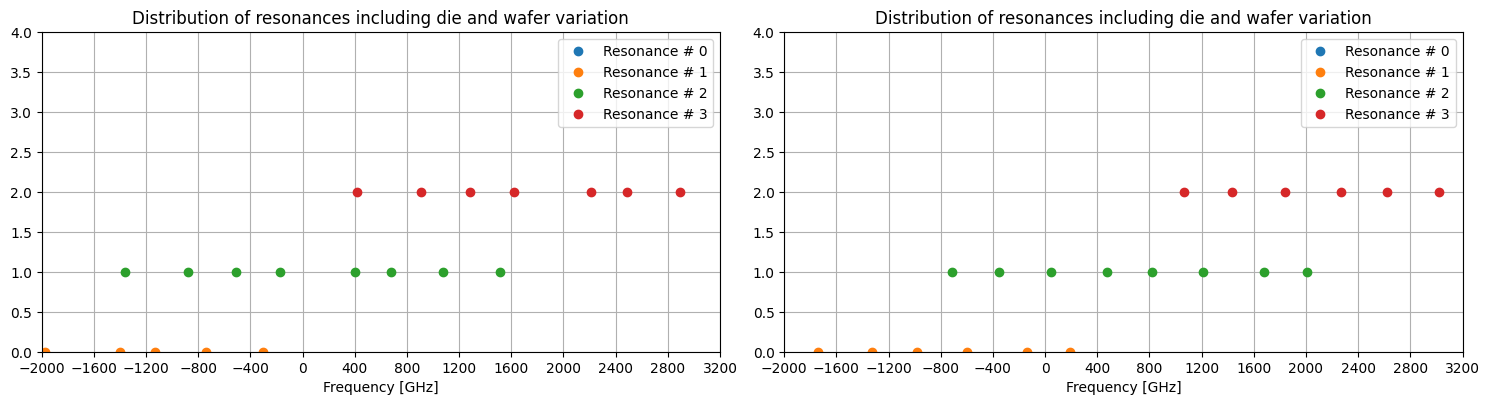

In [18]:
iter_no = 3111
plt.figure(figsize=(15,7.5))
for res_no in [0,1,2,3]:  
  plt.subplot(2,2,1)
  plt.plot(mrm_resonances_die_wafer_variation[:,res_no,iter_no], np.ones(no_mrms)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-2000, 3600, 400))
  plt.ylim([0, 4.0])
  plt.title("Distribution of resonances including die and wafer variation")
  plt.xlabel("Frequency [GHz]")
  plt.subplot(2,2,2)
  plt.plot(crr_resonances_die_wafer_variation[:,res_no,iter_no], np.ones(no_mrms)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-2000, 3600, 400))
  plt.ylim([0, 4.0])
  plt.title("Distribution of resonances including die and wafer variation")
  plt.xlabel("Frequency [GHz]")
plt.tight_layout()

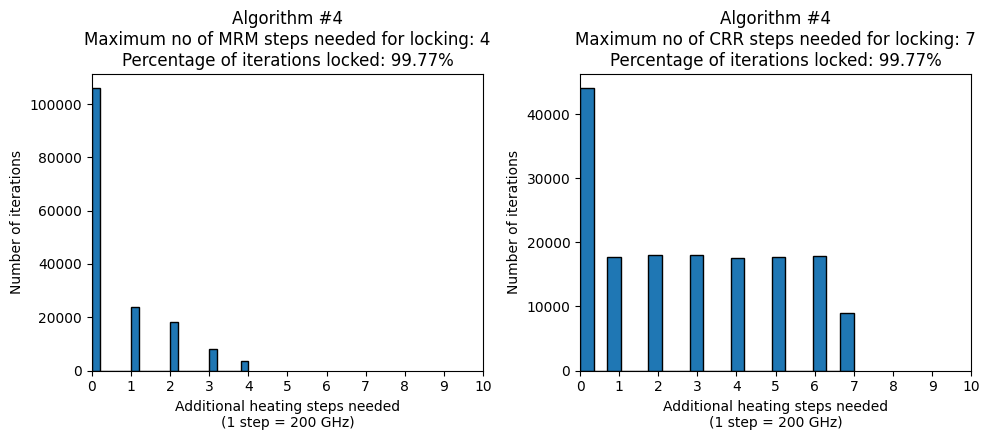

In [264]:
plt.figure(figsize=(10,4.5))

plt.subplot(1,2,1)
plt.hist(mrm_assignment_algo_1[:,2,:].flatten(), rwidth=1.0, bins = 20, edgecolor='k')
plt.xlabel("Additional heating steps needed\n(1 step = 200 GHz)")
plt.ylabel("Number of iterations")
plt.title(f"Algorithm #4\nMaximum no of MRM steps needed for locking: {np.max(mrm_assignment_algo_1[:,2,:].flatten()):0.0f}\nPercentage of iterations locked: {len(iter_assigned_algo_1)/no_iterations*100:0.2f}%")
plt.xticks(np.arange(0, 11, 1))
plt.xlim([0, 10])

plt.subplot(1,2,2)
plt.hist(mrm_assignment_algo_1[:,5,:].flatten(), rwidth=1.0, bins = 20, edgecolor='k')
plt.xlabel("Additional heating steps needed\n(1 step = 200 GHz)")
plt.ylabel("Number of iterations")
plt.title(f"Algorithm #4\nMaximum no of CRR steps needed for locking: {np.max(mrm_assignment_algo_1[:,5,:].flatten()):0.0f}\nPercentage of iterations locked: {len(iter_assigned_algo_1)/no_iterations*100:0.2f}%")
plt.xticks(np.arange(0, 11, 1))
plt.xlim([0, 10])

plt.tight_layout()
plt.show()

In [5]:
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
import itertools
import sys
class ResonanceMapper:
    def __init__(self):
        # Constants
        self.NO_ITERATIONS = int(2e4 + 1)  # 20,001 iterations
        self.NO_MRMS = 8
        self.NO_CRRS = 8
        self.NO_LASER_WAVELENGTHS = 8
        self.NO_RESONANCES = 6
        self.CENTER_RESONANCE = 3
        self.STEP_SWEEP = 200
        self.COOLING = -1.5
        self.HEATING = 1.0
        self.DEBUG = 0

        # MRM-specific constants
        self.MRM_FSR = np.arange(1780, 1825, self.NO_RESONANCES)
        self.MRM_FABRICATION_VARIATION_3SIGMA = 200/4
        self.MRM_OPTICAL_BANDWIDTH = 100

        # CRR-specific constants
        self.CRR_FSR = np.arange(1780, 1825, self.NO_RESONANCES)
        self.CRR_FABRICATION_VARIATION_3SIGMA = 200/4
        self.CRR_OPTICAL_BANDWIDTH = 100

        # Laser frequencies
        self.LASER_FREQUENCY = np.arange(0, 3200, 400)

        # Initialize resonance arrays
        self.initialize_resonance_arrays()
        # Create a list of numbers from 0 to 7
        numbers = list(range(8))

        # Generate all permutations and convert each permutation to a list
        self.mrm_orders = [list(perm) for perm in itertools.permutations(numbers)]

    def initialize_resonance_arrays(self):
        """Initialize resonance arrays for MRMs and CRRs."""
        # MRM resonance arrays
        self.mrm_resonances_die_wafer_variation = np.zeros((self.NO_MRMS, self.NO_RESONANCES, self.NO_ITERATIONS))
        self.mrm_resonances_die_variation = np.zeros((self.NO_MRMS, self.NO_RESONANCES, self.NO_ITERATIONS))
        self.mrm_resonances_wafer_variation = np.zeros((self.NO_MRMS, self.NO_RESONANCES, self.NO_ITERATIONS))
        self.mrm_resonances_ideal = np.zeros((self.NO_MRMS, self.NO_RESONANCES, self.NO_ITERATIONS))

        # CRR resonance arrays
        self.crr_resonances_die_wafer_variation = np.zeros((self.NO_CRRS, self.NO_RESONANCES, self.NO_ITERATIONS))
        self.crr_resonances_die_variation = np.zeros((self.NO_CRRS, self.NO_RESONANCES, self.NO_ITERATIONS))
        self.crr_resonances_wafer_variation = np.zeros((self.NO_CRRS, self.NO_RESONANCES, self.NO_ITERATIONS))
        self.crr_resonances_ideal = np.zeros((self.NO_CRRS, self.NO_RESONANCES, self.NO_ITERATIONS))

    def generate_variations(self):
        """Generate variations for MRMs and CRRs."""
        # MRM variations
        die_variation = np.random.normal(0, 
                                          self.MRM_FABRICATION_VARIATION_3SIGMA, 
                                          size=(self.NO_LASER_WAVELENGTHS, self.NO_ITERATIONS))
        wafer_variation = np.random.uniform(0, np.mean(self.MRM_FSR), self.NO_ITERATIONS)

        # CRR variations
        crr_die_variation = np.random.normal(0, self.CRR_FABRICATION_VARIATION_3SIGMA, 
                                             size=(self.NO_LASER_WAVELENGTHS, self.NO_ITERATIONS))
        crr_wafer_variation = np.random.uniform(0, np.mean(self.CRR_FSR), self.NO_ITERATIONS)

        return die_variation, wafer_variation, crr_die_variation, crr_wafer_variation

    def calculate_resonances(self):
        """Calculate resonances for MRMs and CRRs."""
        die_variation, wafer_variation, crr_die_variation, crr_wafer_variation = self.generate_variations()

        for iter_no in range(self.NO_ITERATIONS):
            for res_no in range(self.NO_RESONANCES):
                base_resonance = np.arange(0, 3200, 400) + (res_no - self.CENTER_RESONANCE) * self.MRM_FSR

                # MRM resonances
                self.mrm_resonances_die_wafer_variation[:, res_no, iter_no] = base_resonance + die_variation[:, iter_no] + wafer_variation[iter_no]
                self.mrm_resonances_die_variation[:, res_no, iter_no] = base_resonance + die_variation[:, iter_no]
                self.mrm_resonances_wafer_variation[:, res_no, iter_no] = base_resonance + wafer_variation[iter_no]
                self.mrm_resonances_ideal[:, res_no, iter_no] = base_resonance

                # CRR resonances
                self.crr_resonances_die_wafer_variation[:, res_no, iter_no] = base_resonance + crr_die_variation[:, iter_no] + crr_wafer_variation[iter_no]
                self.crr_resonances_die_variation[:, res_no, iter_no] = base_resonance + crr_die_variation[:, iter_no]
                self.crr_resonances_wafer_variation[:, res_no, iter_no] = base_resonance + crr_wafer_variation[iter_no]
                self.crr_resonances_ideal[:, res_no, iter_no] = base_resonance
    
    def mrm_to_laser_mapping(self, mrm_resonances_iter, crr_resonances_iter, steplist, mrmlist):
        """Map MRMs to lasers."""
        mrm_assigned = []
        crr_assigned = []
        laser_assigned = []
        resonance_assigned = []
        crr_resonance_assigned = []
        step_assigned = []
        crr_step_assigned = []
        crr_final_heating = []
        mrm_final_heating = []

        for mrm_no in mrmlist:
            locked_bool = False
            for step_no in steplist:
                if step_no > 5:
                    try:
                        if laser_assigned[mrm_assigned.index(8)] == 2:
                            a = 1
                    except:
                        a = 1
                    return True, (mrm_assigned, crr_assigned, laser_assigned, resonance_assigned, 
                                  crr_resonance_assigned, step_assigned, crr_step_assigned, 
                                  crr_final_heating, mrm_final_heating)
                
                for laser_no in range(self.NO_LASER_WAVELENGTHS):
                    if laser_no not in laser_assigned:
                        resonances_location = mrm_resonances_iter[mrm_no, :] - self.LASER_FREQUENCY[laser_no] + self.HEATING * step_no * self.STEP_SWEEP

                        for mrm_res_no in range(self.NO_RESONANCES):
                            if -self.STEP_SWEEP - self.MRM_OPTICAL_BANDWIDTH <= resonances_location[mrm_res_no] <= 0:
                                for crr_step_no in range(6):
                                    crr_resonances_location = crr_resonances_iter[mrm_no, :] - self.LASER_FREQUENCY[laser_no] + self.HEATING * crr_step_no * self.STEP_SWEEP

                                    for crr_res_no in range(self.NO_RESONANCES):
                                        if -self.STEP_SWEEP - self.CRR_OPTICAL_BANDWIDTH <= crr_resonances_location[crr_res_no] <= 0:
                                            crr_assigned.append(mrm_no)
                                            crr_resonance_assigned.append(crr_res_no)
                                            crr_step_assigned.append(crr_step_no)
                                            crr_final_heating.append(crr_resonances_iter[mrm_no, crr_res_no] - self.LASER_FREQUENCY[laser_no])
                                            mrm_final_heating.append(mrm_resonances_iter[mrm_no, mrm_res_no] - self.LASER_FREQUENCY[laser_no])
                                            mrm_assigned.append(mrm_no)
                                            laser_assigned.append(laser_no)
                                            resonance_assigned.append(mrm_res_no)
                                            step_assigned.append(step_no)
                                            locked_bool = True
                                            break
                                    if locked_bool:
                                        break
                            if locked_bool:
                                break
                    if locked_bool:
                        break
                if locked_bool:
                    break

        return False, (mrm_assigned, crr_assigned, laser_assigned, resonance_assigned, 
                       crr_resonance_assigned, step_assigned, crr_step_assigned, 
                       crr_final_heating, mrm_final_heating)

    def run_algorithm(self):
        """Run the main algorithm using a recursive approach."""
        mrm_assignment_algo_1 = np.zeros((self.NO_LASER_WAVELENGTHS, 8, self.NO_ITERATIONS))
        iter_assigned_algo_1 = []

        for iter_no in range(self.NO_ITERATIONS):
            mrm_resonances_iter = self.mrm_resonances_die_wafer_variation[:, :, iter_no]
            crr_resonances_iter = self.crr_resonances_die_wafer_variation[:, :, iter_no]
            if iter_no % 1000 == 0:
                print(f"Running iteration {iter_no}")
            success, results = self.recursive_mapping(mrm_resonances_iter, crr_resonances_iter, 0, 0)

            if success:
                (mrm_assigned, crr_assigned, laser_assigned, resonance_assigned, 
                 crr_resonance_assigned, step_assigned, crr_step_assigned, 
                 crr_final_heating, mrm_final_heating) = results

                if len(mrm_assigned) == self.NO_LASER_WAVELENGTHS and len(crr_assigned) == self.NO_LASER_WAVELENGTHS:
                    iter_assigned_algo_1.append(iter_no)
                    mrm_assignment_algo_1[:, 0, iter_no] = np.array(laser_assigned)
                    mrm_assignment_algo_1[:, 1, iter_no] = np.array(resonance_assigned)
                    mrm_assignment_algo_1[:, 2, iter_no] = np.array(step_assigned)
                    mrm_assignment_algo_1[:, 3, iter_no] = self.LASER_FREQUENCY[laser_assigned]
                    mrm_assignment_algo_1[:, 4, iter_no] = np.array(crr_resonance_assigned)
                    mrm_assignment_algo_1[:, 5, iter_no] = np.array(crr_step_assigned)
                    mrm_assignment_algo_1[:, 6, iter_no] = np.array(crr_final_heating)
                    mrm_assignment_algo_1[:, 7, iter_no] = np.array(mrm_final_heating)
            else:
                print(f"Failed to lock {iter_no}")

        return iter_assigned_algo_1, mrm_assignment_algo_1

    def recursive_mapping(self, mrm_resonances_iter, crr_resonances_iter, start_step, depth):
        """
        Recursively attempt to map MRMs to lasers with different configurations.
        
        Args:
        mrm_resonances_iter: MRM resonances for the current iteration
        crr_resonances_iter: CRR resonances for the current iteration
        start_step: The starting step for the current attempt
        depth: The current depth of recursion, used to change MRM order
        
        Returns:
        success: Boolean indicating whether mapping was successful
        results: Tuple containing the mapping results
        """
        #if depth > 28000:  # Max recursion depth to avoid infinite loops
        #    return False, None
        for step in range(start_step, 6):
            for mrm_order in self.mrm_orders:
            
                fail, results = self.mrm_to_laser_mapping(mrm_resonances_iter, crr_resonances_iter, 
                                                        range(start_step, 20), mrm_order)
                if not fail:
                    return True, results
        return False,None

    def print_results(self, iter_assigned_algo_1, mrm_assignment_algo_1):
        """Print the results of the algorithm."""
        print(f"Algorithm #1, Locked iterations: {len(iter_assigned_algo_1)}, Max MRR steps needed: {np.max(mrm_assignment_algo_1[:, 2, :])}")
        print(f"Algorithm #1, Locked iterations: {len(iter_assigned_algo_1)}, Max CRR steps needed: {np.max(mrm_assignment_algo_1[:, 5, :])}")
        print(f"CRR heating: {(np.max(mrm_assignment_algo_1[:,6 , :]-np.min(mrm_assignment_algo_1[:,6 , :])))/200}, MRM Heating: {(np.max(mrm_assignment_algo_1[:, 7, :])-np.min(mrm_assignment_algo_1[:, 7, :]))/200}")

In [6]:
mapper = ResonanceMapper()
mapper.calculate_resonances()
iter_assigned_algo_1, mrm_assignment_algo_1 = mapper.run_algorithm()
mapper.print_results(iter_assigned_algo_1, mrm_assignment_algo_1)

Running iteration 0
Running iteration 1000


KeyboardInterrupt: 

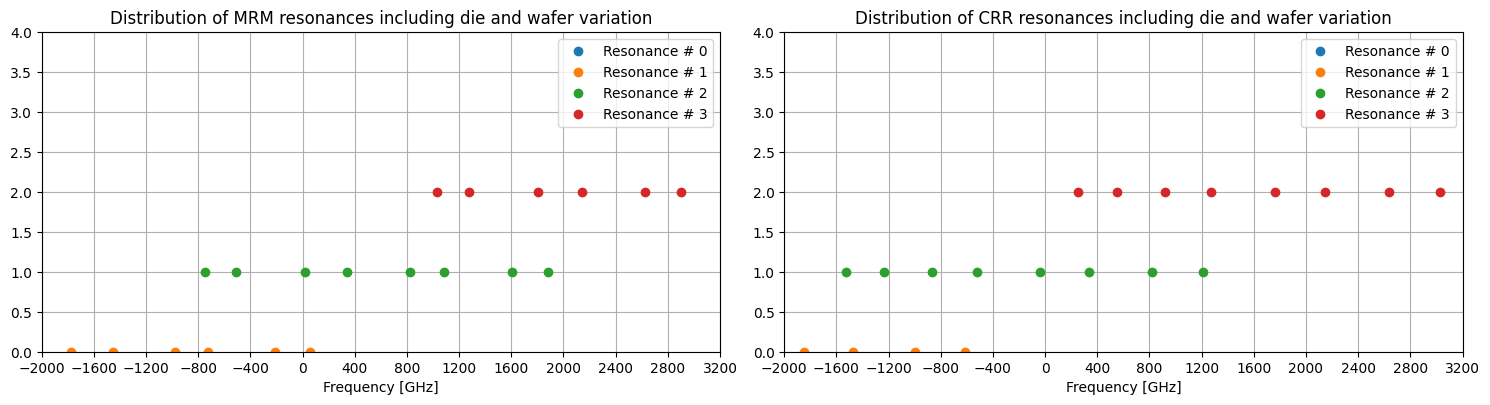

In [28]:
iter_no = 3111
plt.figure(figsize=(15,7.5))
for res_no in [0,1,2,3]:  
  plt.subplot(2,2,1)
  plt.plot(mapper.mrm_resonances_die_wafer_variation[:,res_no,iter_no], np.ones(8)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-2000, 3600, 400))
  plt.ylim([0, 4.0])
  plt.title("Distribution of MRM resonances including die and wafer variation")
  plt.xlabel("Frequency [GHz]")
  plt.subplot(2,2,2)
  plt.plot(mapper.crr_resonances_die_wafer_variation[:,res_no,iter_no], np.ones(8)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-2000, 3600, 400))
  plt.ylim([0, 4.0])
  plt.title("Distribution of CRR resonances including die and wafer variation")
  plt.xlabel("Frequency [GHz]")
plt.tight_layout()

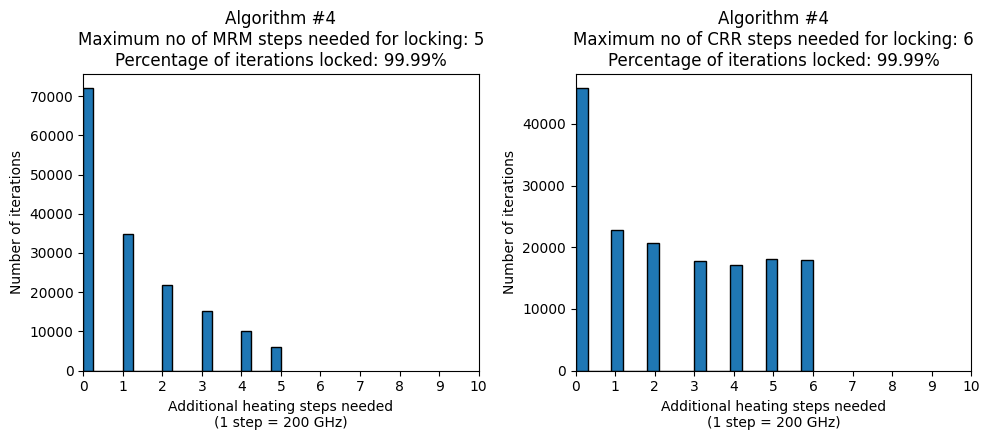

In [14]:
plt.figure(figsize=(10,4.5))

plt.subplot(1,2,1)
plt.hist(mrm_assignment_algo_1[:,2,:].flatten(), rwidth=1.0, bins = 20, edgecolor='k')
plt.xlabel("Additional heating steps needed\n(1 step = 200 GHz)")
plt.ylabel("Number of iterations")
plt.title(f"Algorithm #4\nMaximum no of MRM steps needed for locking: {np.max(mrm_assignment_algo_1[:,2,:].flatten()):0.0f}\nPercentage of iterations locked: {len(iter_assigned_algo_1)/mapper.NO_ITERATIONS*100:0.2f}%")
plt.xticks(np.arange(0, 11, 1))
plt.xlim([0, 10])

plt.subplot(1,2,2)
plt.hist(mrm_assignment_algo_1[:,5,:].flatten(), rwidth=1.0, bins = 20, edgecolor='k')
plt.xlabel("Additional heating steps needed\n(1 step = 200 GHz)")
plt.ylabel("Number of iterations")
plt.title(f"Algorithm #4\nMaximum no of CRR steps needed for locking: {np.max(mrm_assignment_algo_1[:,5,:].flatten()):0.0f}\nPercentage of iterations locked: {len(iter_assigned_algo_1)/mapper.NO_ITERATIONS*100:0.2f}%")
plt.xticks(np.arange(0, 11, 1))
plt.xlim([0, 10])

plt.tight_layout()
plt.show()

In [15]:

class MRM:
    def __init__(self):
       
        # MRM-specific constants
        self.locked = False
        self.mrm_location = 0
        self.pd_ouput = 0

    def get_pdPower(self,lasers):
        for l in lasers:
            if l < self.mrm_location + 50 and l > self.mrm_location - 50:
                self.pd_output = 50 - abs(l-self.mrm_location)
        return self.pd_output

